<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/27_GAN_Image_Generation/27_Image_Generation_with_ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation with Progressive GAN (ProGAN) Model**

## **Pretrained ProGAN (CelebA Faces) from TF-Hub**

In [59]:
# Install imageio for creating animations.
!pip -q install imageio scikit-image git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [60]:
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
from skimage import transform
from absl import logging
import time

In [61]:
logging.set_verbosity(logging.ERROR)
tf.random.set_seed(0)

# --- Load pretrained Progressive GAN (CelebA Faces) ---
latent_dim = 512
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']

In [62]:
# --- Helper functions ---
def interpolate_hypersphere(v1, v2, num_steps=50):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)
    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

def display_image(image):
    image = tf.constant(image)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return PIL.Image.fromarray(image.numpy())

def animate(images, filename="./animation.gif"):
    images = np.array(images)
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave(filename, converted_images)
    return embed.embed_file(filename)


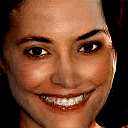

In [63]:
# --- Latent Interpolation (between two random faces) ---
def interpolate_between_vectors():
    v1 = tf.random.normal([latent_dim])
    v2 = tf.random.normal([latent_dim])
    vectors = interpolate_hypersphere(v1, v2, num_steps=40)
    interpolated_images = progan(vectors)['default']
    return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

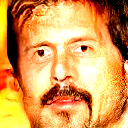

In [64]:
# --- Target Image & Optimization ---
target_image = progan(tf.random.normal([1, latent_dim]))['default'][0]
display_image(target_image)

In [71]:
def find_closest_latent_vector(initial_vector, target_image, num_steps=200, steps_per_image=5):
    images, losses = [], []
    vector = tf.Variable(initial_vector)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

    for step in range(num_steps):
        with tf.GradientTape() as tape:
            image = progan(vector)['default'][0]
            if step % steps_per_image == 0:
                images.append(image.numpy())
            image_loss = loss_fn(image, target_image[:, :, :3])
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
            loss = image_loss + regularizer
            losses.append(loss.numpy())
        grads = tape.gradient(loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))
    return images, losses

initial_vector = tf.random.normal([1, latent_dim])
images, losses = find_closest_latent_vector(initial_vector, target_image)

/tmp/ipython-input-2989940693.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


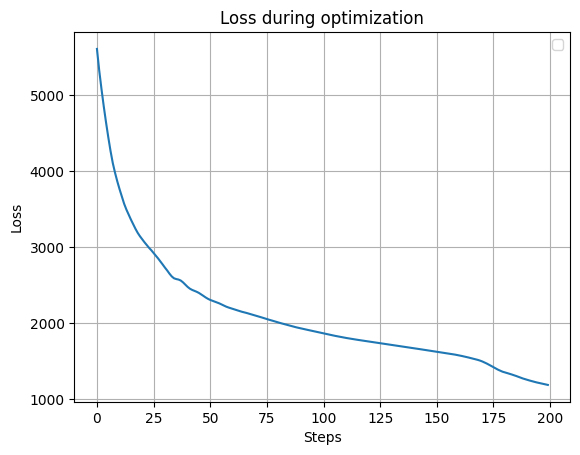

In [72]:
plt.plot(losses)
plt.title("Loss during optimization")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


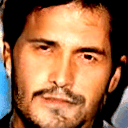

In [67]:
animate(np.stack(images))

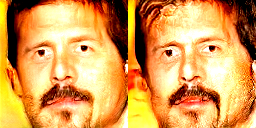

In [68]:
final_image = images[-1]
display_image(np.concatenate([final_image, target_image], axis=1))

## **Part 2: Train/Test-style loss curves (NEW)**

In [73]:
# --- NEW: Run latent optimization for multiple targets and average losses ---
def evaluate_on_targets(num_targets=5, num_steps=200):
    all_losses = []
    for _ in range(num_targets):
        target = progan(tf.random.normal([1, latent_dim]))['default'][0]
        init_vec = tf.random.normal([1, latent_dim])
        _, losses = find_closest_latent_vector(init_vec, target, num_steps=num_steps)
        all_losses.append(losses)
    return np.mean(all_losses, axis=0)

train_losses = evaluate_on_targets(num_targets=5)
test_losses = evaluate_on_targets(num_targets=5)

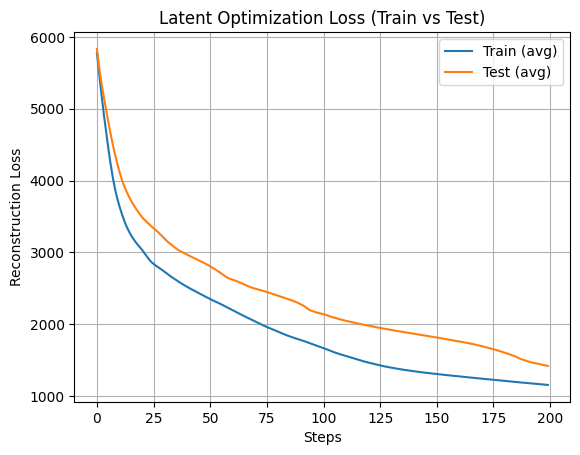

In [74]:
# Plot both
plt.plot(train_losses, label="Train (avg)")
plt.plot(test_losses, label="Test (avg)")
plt.xlabel("Steps")
plt.ylabel("Reconstruction Loss")
plt.title("Latent Optimization Loss (Train vs Test)")
plt.legend()
plt.grid(True)
plt.show()